### Librerias

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from datetime import datetime, timedelta


### Gráficas

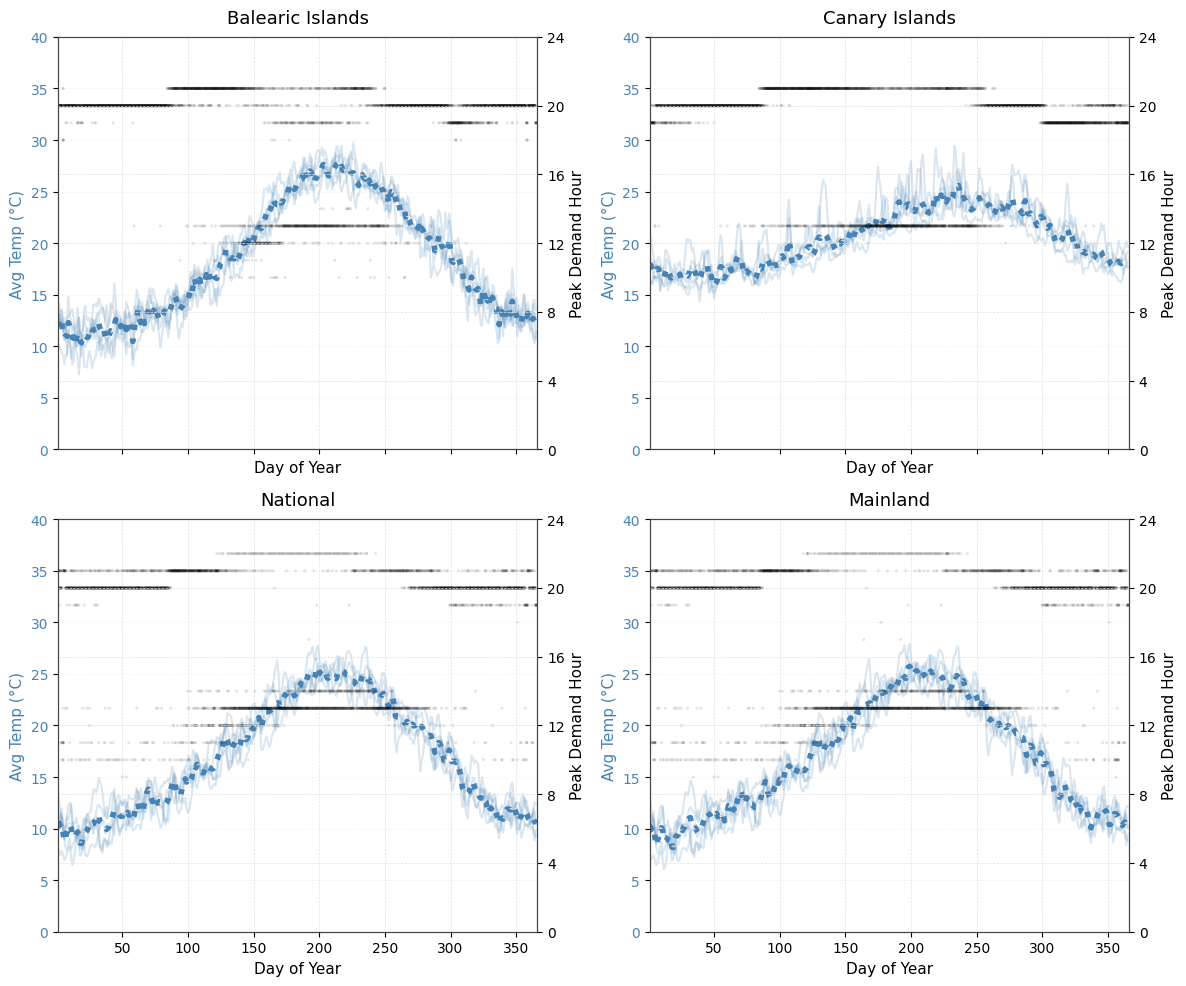

In [11]:
df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['day_of_year'] = df['fecha'].dt.dayofyear
df['year'] = df['fecha'].dt.year

region_names_en = {
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
}

temp_cols = [f'temperatura_{i}' for i in range(24)]
df['avg_temp'] = df[temp_cols].mean(axis=1)

demand_cols = [f'demanda_{i}' for i in range(24)]
df['peak_hour'] = df[demand_cols].idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

years = sorted(df['year'].unique())
year_pairs = [years[i:i+2] for i in range(0, len(years), 2)]

regions = df['region'].unique()
n_regions = len(regions)
n_cols = 2

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#444444",
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

fig, axes = plt.subplots(2, n_cols, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for i, region in enumerate(regions):
    ax1 = axes[i]
    region_data = df[df['region'] == region]
    translated_name = region_names_en.get(region, region)

    ax1.set_title(translated_name, pad=10)
    ax1.set_ylim(0, 40)
    ax1.set_xlim(1, 366)
    ax1.set_xlabel("Day of Year")
    ax1.set_ylabel("Avg Temp (°C)", color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.4)

    for pair in year_pairs:
        pair_data = region_data[region_data['year'].isin(pair)]
        grouped = (
            pair_data.groupby('day_of_year')['avg_temp']
            .mean()
            .reindex(range(1, 366))
            .interpolate(method='linear')
            .reset_index()
        )
        label = f"{pair[0]}–{pair[1]}" if len(pair) == 2 else f"{pair[0]}"
        ax1.plot(grouped['day_of_year'], grouped['avg_temp'],
                 color='steelblue', alpha=0.2, linewidth=1.5, label=label)

    mean_all_years = (
        region_data.groupby('day_of_year')['avg_temp']
        .mean()
        .reindex(range(1, 366))
        .interpolate(method='linear')
        .reset_index()
    )
    ax1.plot(mean_all_years['day_of_year'], mean_all_years['avg_temp'],
             color='steelblue', linestyle=':', linewidth=4, label='All Years Mean')

    ax2 = ax1.twinx()
    ax2.set_ylim(0, 24)
    ax2.set_ylabel("Peak Demand Hour", color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_yticks(range(0, 25, 4))
    ax2.scatter(region_data['day_of_year'], region_data['peak_hour'],
                color='black', alpha=0.1, s=5, edgecolors='none')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


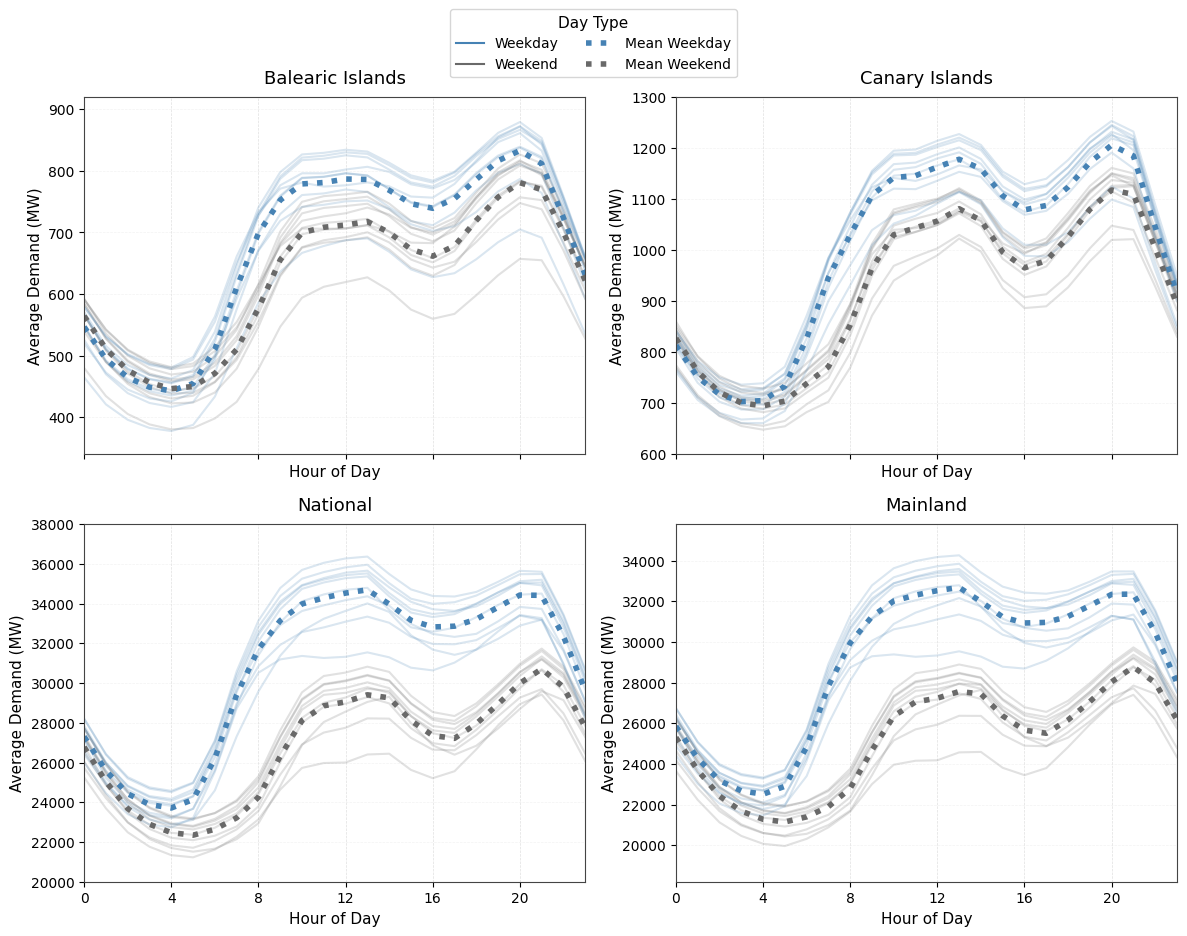

In [12]:


df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['weekday'] = df['fecha'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])
df['region'] = df['region'].map({
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
})
df['year'] = df['fecha'].dt.year

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#444444",
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

records = []
for hour in range(24):
    col = f'demanda_{hour}'
    for idx, row in df.iterrows():
        records.append({
            'region': row['region'],
            'year': row['year'],
            'hour': hour,
            'type': 'Weekend' if row['is_weekend'] else 'Weekday',
            'demand': row[col]
        })

df_plot = pd.DataFrame(records)

region_order = ['Balearic Islands', 'Canary Islands', 'National', 'Mainland']
type_order = ['Weekday', 'Weekend']
color_map = {'Weekday': 'steelblue', 'Weekend': 'dimgray'}

manual_ylim = {
    'Balearic Islands': (340, 920),
    'Canary Islands': (600, 1300),
    'National': (20000, 38000),
    'Mainland': (18200, 35800)
}

use_manual_ylim = {
    'Balearic Islands': True,
    'Canary Islands': True,
    'National': True,
    'Mainland': True
}

n_regions = len(region_order)
n_cols = 2
fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 10), sharex=True)
axes = axes.flatten()

for j, region in enumerate(region_order):
    ax = axes[j]
    region_data = df_plot[df_plot['region'] == region]

    ax.set_title(region, pad=10)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 4))
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Average Demand (MW)")
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.4)

    if use_manual_ylim[region]:
        y_lower, y_upper = manual_ylim[region]
    else:
        y_min = region_data['demand'].min()
        y_max = region_data['demand'].max()
        y_range = y_max - y_min
        y_lower = y_min - 0.025 * y_range
        y_upper = y_max + 0.025 * y_range

    ax.set_ylim(y_lower, y_upper)

    for year in sorted(region_data['year'].unique()):

        for typ in type_order:
            year_type_data = region_data[(region_data['year'] == year) & (region_data['type'] == typ)]
            grouped = year_type_data.groupby('hour')['demand'].mean().reset_index()
            ax.plot(grouped['hour'], grouped['demand'],
                    color=color_map[typ],
                    alpha=0.2, linewidth=1.5)
            
    for typ in type_order:
        mean_data = region_data[region_data['type'] == typ]
        grouped_mean = mean_data.groupby('hour')['demand'].mean().reset_index()
        ax.plot(grouped_mean['hour'], grouped_mean['demand'],
                color=color_map[typ],
                alpha=1.0, linewidth=4.0,
                linestyle=':')


for k in range(j + 1, len(axes)):
    fig.delaxes(axes[k])

mean_handles = [
    Line2D([0], [0], color='steelblue', linestyle=':', linewidth=4, label='Mean Weekday'),
    Line2D([0], [0], color='dimgray', linestyle=':', linewidth=4, label='Mean Weekend')
]

default_handles = [
    Line2D([0], [0], color='steelblue', linewidth=1.5, alpha=1.0, label='Weekday'),
    Line2D([0], [0], color='dimgray', linewidth=1.5, alpha=1.0, label='Weekend'),
]

all_handles = default_handles + mean_handles
fig.legend(handles=all_handles, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=2, fontsize=10, title="Day Type")


plt.tight_layout(rect=[0, 0, 1, 0.89])
plt.show()


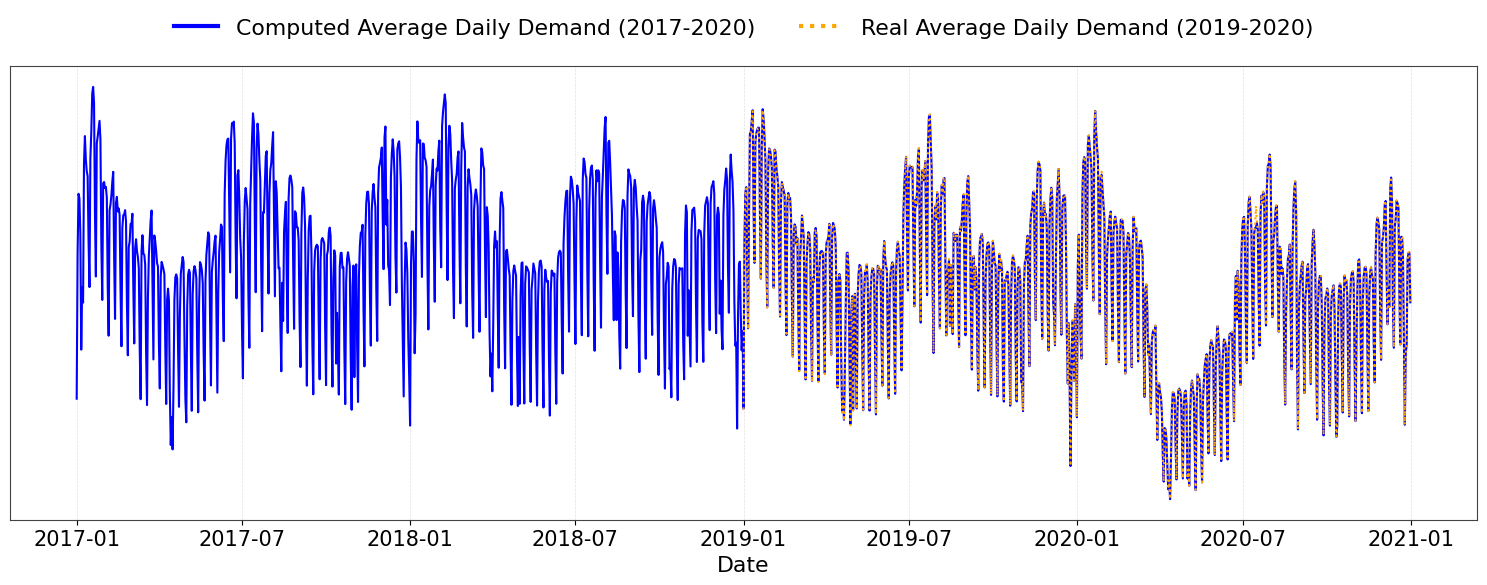

In [13]:

df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['region'] = df['region'].map({
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
})

df = df[(df['fecha'] >= '2017-01-01') & (df['fecha'] <= '2020-12-31')]

hour_cols = [f'demanda_{i}' for i in range(24)]
df['avg_demand_day'] = df[hour_cols].mean(axis=1)

df_national = df[df['region'] == 'National']
df_others = df[df['region'] != 'National']

national_avg = df_national.groupby('fecha')['avg_demand_day'].mean()

others_avg_per_region = df_others.groupby(['fecha', 'region'])['avg_demand_day'].mean().reset_index()
others_sum_per_day = others_avg_per_region.groupby('fecha')['avg_demand_day'].sum()

others_adjusted = others_sum_per_day + 48.51

all_days = pd.date_range(start='2017-01-01', end='2020-12-31')
national_avg = national_avg.reindex(all_days)
others_adjusted = others_adjusted.reindex(all_days)


plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#444444",
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

plt.figure(figsize=(15, 6))

mask_oth = (others_adjusted.index.year <= 2020)
plt.plot(others_adjusted.index[mask_oth], others_adjusted[mask_oth],
         label='Sum of Other Regions + 48.51 (2017–2020)', color='blue', alpha=1)

mask_nat = (national_avg.index.year >= 2019)
plt.plot(national_avg.index[mask_nat], national_avg[mask_nat],
         label='National Avg Demand (2019–2020)', color='orange', alpha=1, linestyle=":")

custom_legend = [
    Line2D([0], [0], color='blue', lw=3, label='Computed Average Daily Demand (2017-2020)', linestyle='-'),
    Line2D([0], [0], color='orange', lw=3, label='Real Average Daily Demand (2019-2020)', linestyle=':')
]

plt.legend(
    handles=custom_legend,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  
    fontsize='x-large',
    ncol=2, 
    frameon=False  
)

plt.xlabel('Date', fontsize='x-large')      
plt.yticks([])  
plt.xticks(fontsize=15)


plt.grid(True)
plt.tight_layout()
plt.show()


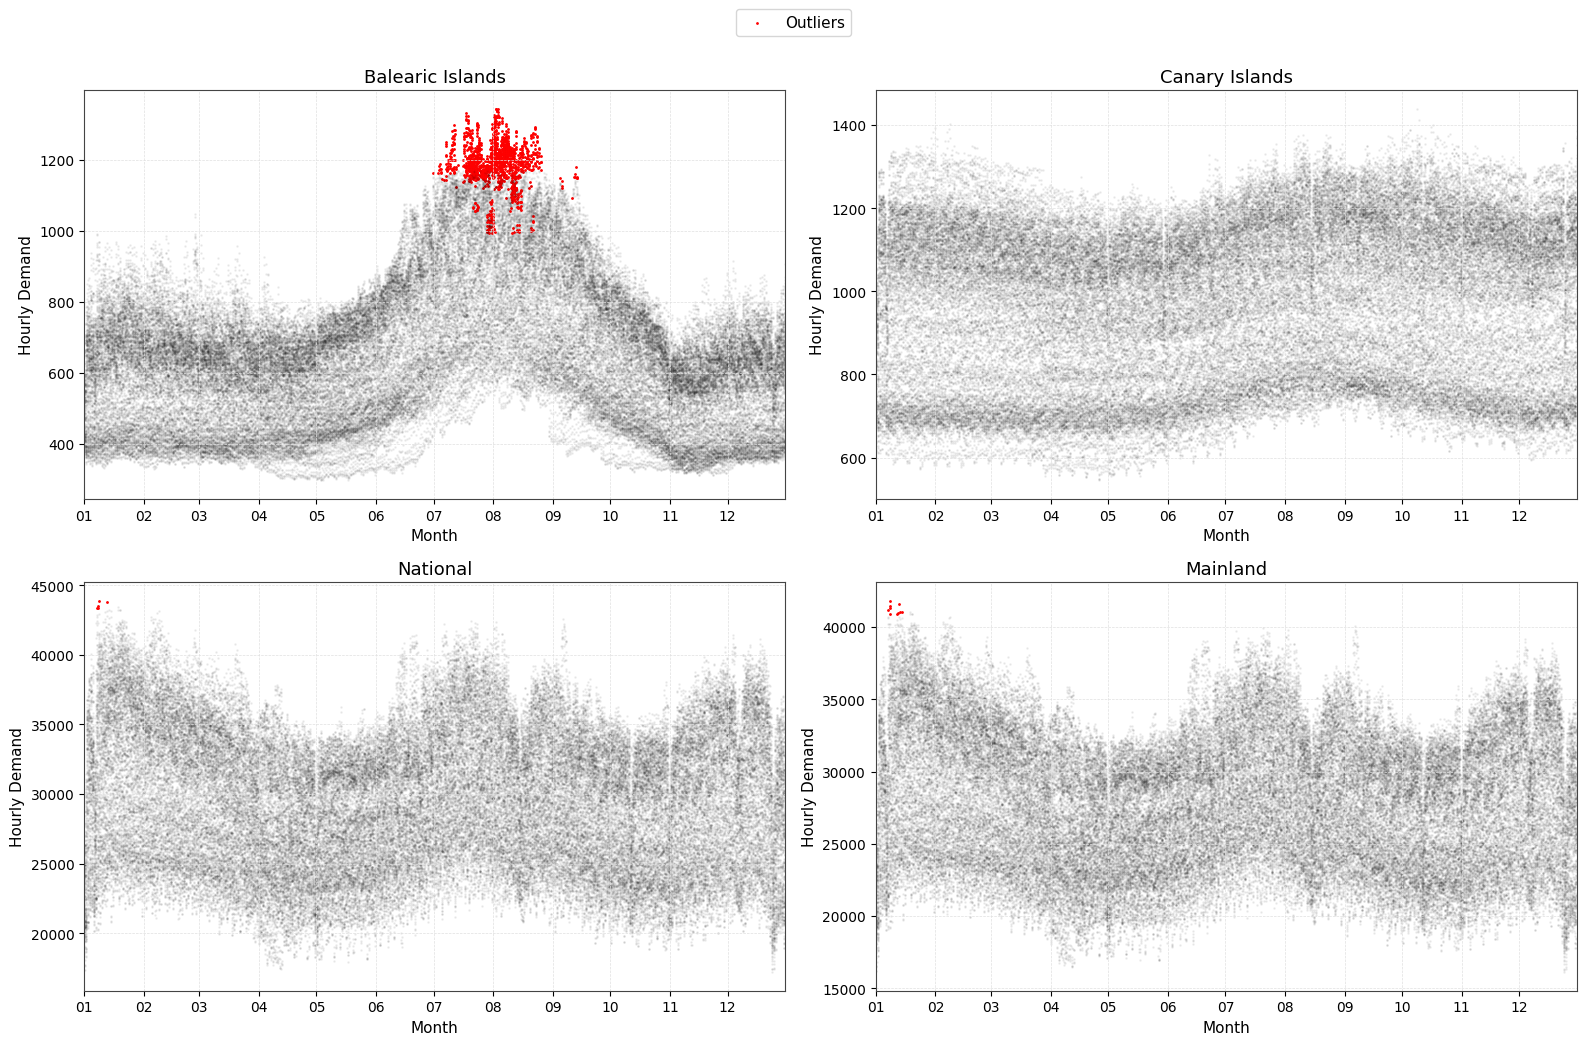

In [14]:
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#444444",
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['region'] = df['region'].map({
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
})

df = df.dropna(subset=['region'])

df['year'] = df['fecha'].dt.year
df['day_of_year'] = df['fecha'].dt.dayofyear

regions = ['Balearic Islands', 'Canary Islands', 'National', 'Mainland']
hour_cols = [f'demanda_{i}' for i in range(24)]
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = df[df['region'] == region].copy()
    region_df['date'] = pd.to_datetime(region_df['fecha'])
    ax = axes[i]

    for year, group in region_df.groupby('year'):
        group = group.sort_values('fecha')
        hourly_values = []
        hour_indices = []

        hour_counter = 0
        for _, row in group.iterrows():
            for h in range(24):
                value = row[f'demanda_{h}']
                hourly_values.append(value)
                hour_indices.append(hour_counter)
                hour_counter += 1

        ax.scatter(hour_indices, hourly_values, color='black', alpha=0.05, s=1)

        series = pd.Series(hourly_values)
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (series < lower) | (series > upper)

        outlier_x = [hour_indices[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        outlier_y = [hourly_values[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        ax.scatter(outlier_x, outlier_y, color='red', s=1, label='Outliers' if year == list(region_df['year'].unique())[0] else None)

    month_starts = pd.date_range(start='2020-01-01', end='2020-12-31', freq='MS')
    month_hours = [(m - pd.Timestamp('2020-01-01')).days * 24 for m in month_starts]
    month_labels = [m.strftime('%m') for m in month_starts]

    ax.set_xticks(month_hours)
    ax.set_xticklabels(month_labels)
    ax.set_xlim(0, 365 * 24 - 1)
    ax.set_title(region)
    ax.set_xlabel('Month')
    ax.set_ylabel('Hourly Demand')
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()


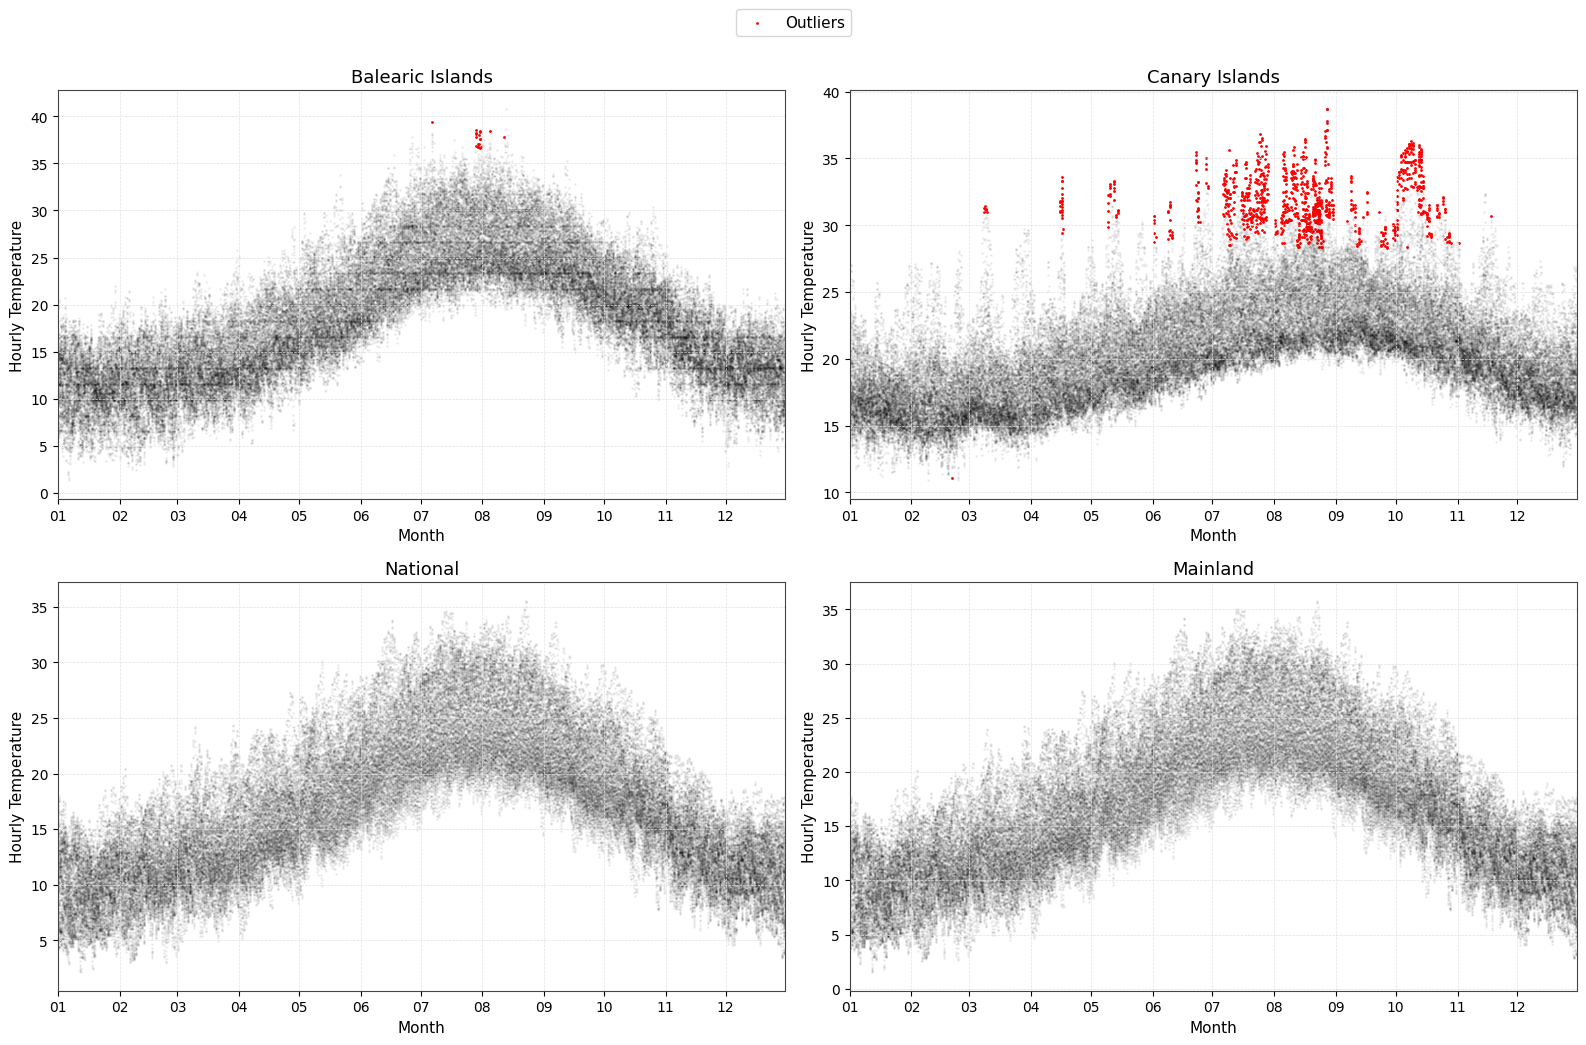

In [15]:
df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['region'] = df['region'].map({
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
})

df = df.dropna(subset=['region'])

df['year'] = df['fecha'].dt.year
df['day_of_year'] = df['fecha'].dt.dayofyear

regions = ['Balearic Islands', 'Canary Islands', 'National', 'Mainland']
hour_cols = [f'temperatura_{i}' for i in range(24)]
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = df[df['region'] == region].copy()
    region_df['date'] = pd.to_datetime(region_df['fecha'])
    ax = axes[i]

    for year, group in region_df.groupby('year'):
        group = group.sort_values('fecha')
        hourly_values = []
        hour_indices = []

        hour_counter = 0
        for _, row in group.iterrows():
            for h in range(24):
                value = row[f'temperatura_{h}']
                hourly_values.append(value)
                hour_indices.append(hour_counter)
                hour_counter += 1

        ax.scatter(hour_indices, hourly_values, color='black', alpha=0.05, s=1)

        series = pd.Series(hourly_values)
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (series < lower) | (series > upper)

        outlier_x = [hour_indices[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        outlier_y = [hourly_values[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        ax.scatter(outlier_x, outlier_y, color='red', s=1, label='Outliers' if year == list(region_df['year'].unique())[0] else None)

    month_starts = pd.date_range(start='2020-01-01', end='2020-12-31', freq='MS')
    month_hours = [(m - pd.Timestamp('2020-01-01')).days * 24 for m in month_starts]
    month_labels = [m.strftime('%m') for m in month_starts]

    ax.set_xticks(month_hours)
    ax.set_xticklabels(month_labels)
    ax.set_xlim(0, 365 * 24 - 1)
    ax.set_title(region)
    ax.set_xlabel('Month')
    ax.set_ylabel('Hourly Temperature')
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()


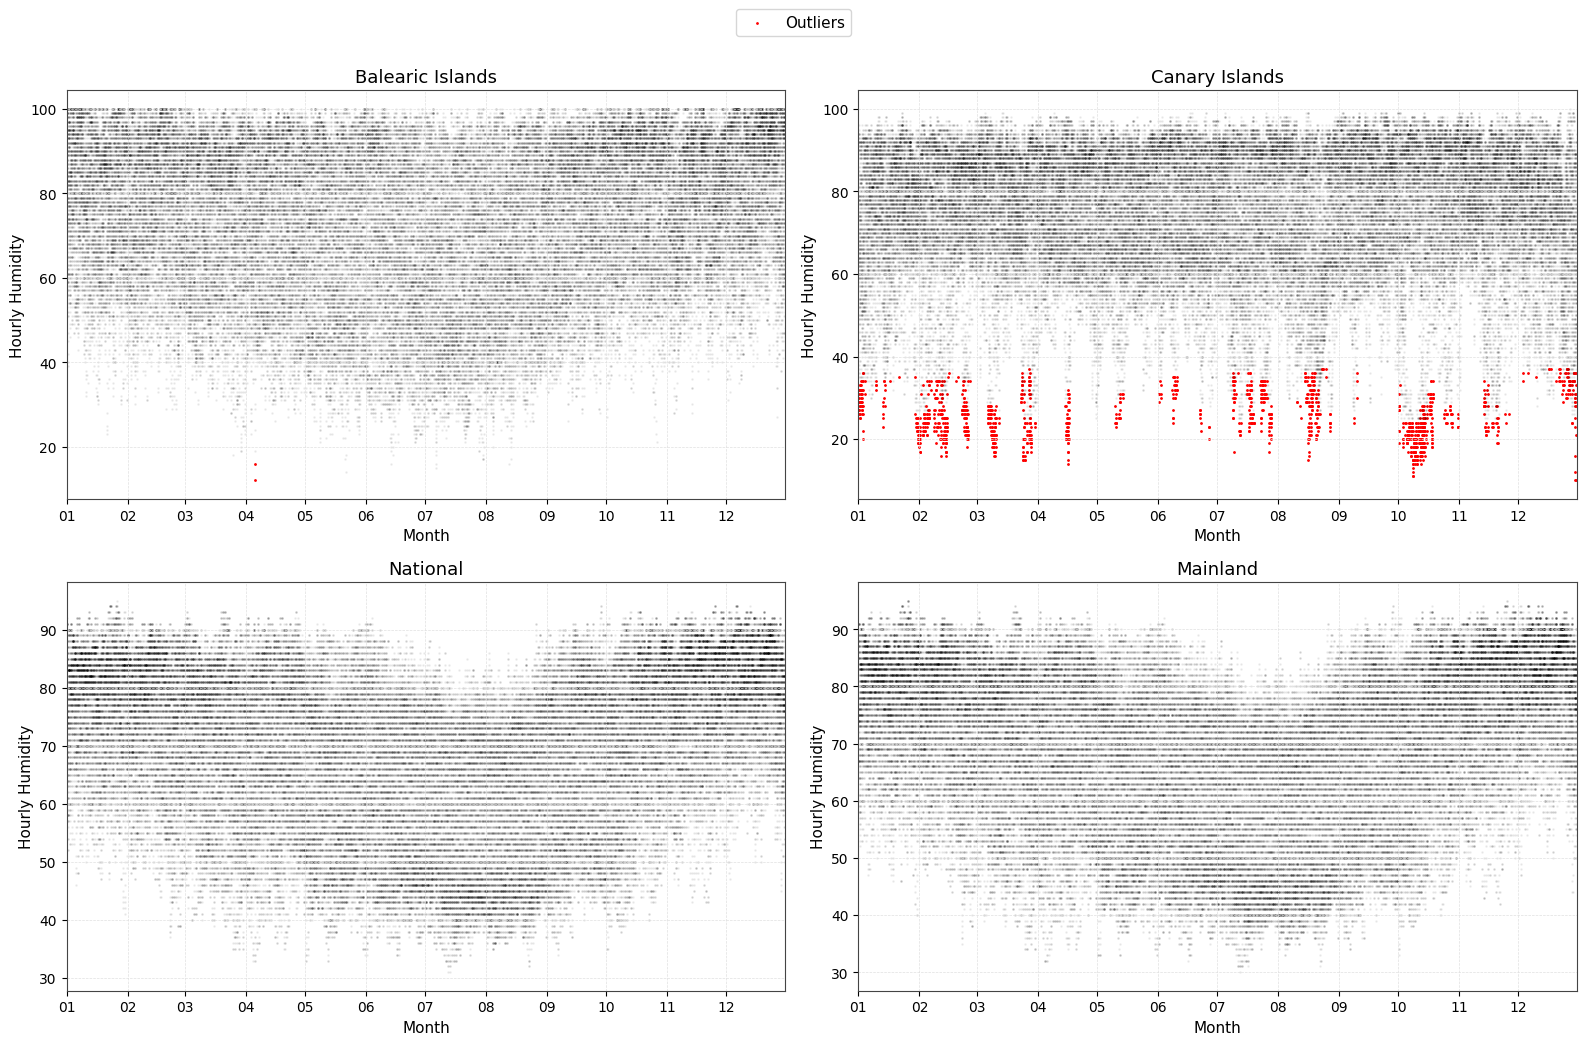

In [16]:
df = pd.read_csv('data.csv', parse_dates=['fecha'])

df['region'] = df['region'].map({
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
})

df = df.dropna(subset=['region'])

df['year'] = df['fecha'].dt.year
df['day_of_year'] = df['fecha'].dt.dayofyear

regions = ['Balearic Islands', 'Canary Islands', 'National', 'Mainland']
hour_cols = [f'humedad_{i}' for i in range(24)]
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = df[df['region'] == region].copy()
    region_df['date'] = pd.to_datetime(region_df['fecha'])
    ax = axes[i]

    for year, group in region_df.groupby('year'):
        group = group.sort_values('fecha')
        hourly_values = []
        hour_indices = []

        hour_counter = 0
        for _, row in group.iterrows():
            for h in range(24):
                value = row[f'humedad_{h}']
                hourly_values.append(value)
                hour_indices.append(hour_counter)
                hour_counter += 1

        ax.scatter(hour_indices, hourly_values, color='black', alpha=0.05, s=1)

        series = pd.Series(hourly_values)
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (series < lower) | (series > upper)

        outlier_x = [hour_indices[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        outlier_y = [hourly_values[j] for j in range(len(hour_indices)) if outlier_mask.iloc[j]]
        ax.scatter(outlier_x, outlier_y, color='red', s=1, label='Outliers' if year == list(region_df['year'].unique())[0] else None)

    month_starts = pd.date_range(start='2020-01-01', end='2020-12-31', freq='MS')
    month_hours = [(m - pd.Timestamp('2020-01-01')).days * 24 for m in month_starts]
    month_labels = [m.strftime('%m') for m in month_starts]

    ax.set_xticks(month_hours)
    ax.set_xticklabels(month_labels)
    ax.set_xlim(0, 365 * 24 - 1)
    ax.set_title(region)
    ax.set_xlabel('Month')
    ax.set_ylabel('Hourly Humidity')
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()


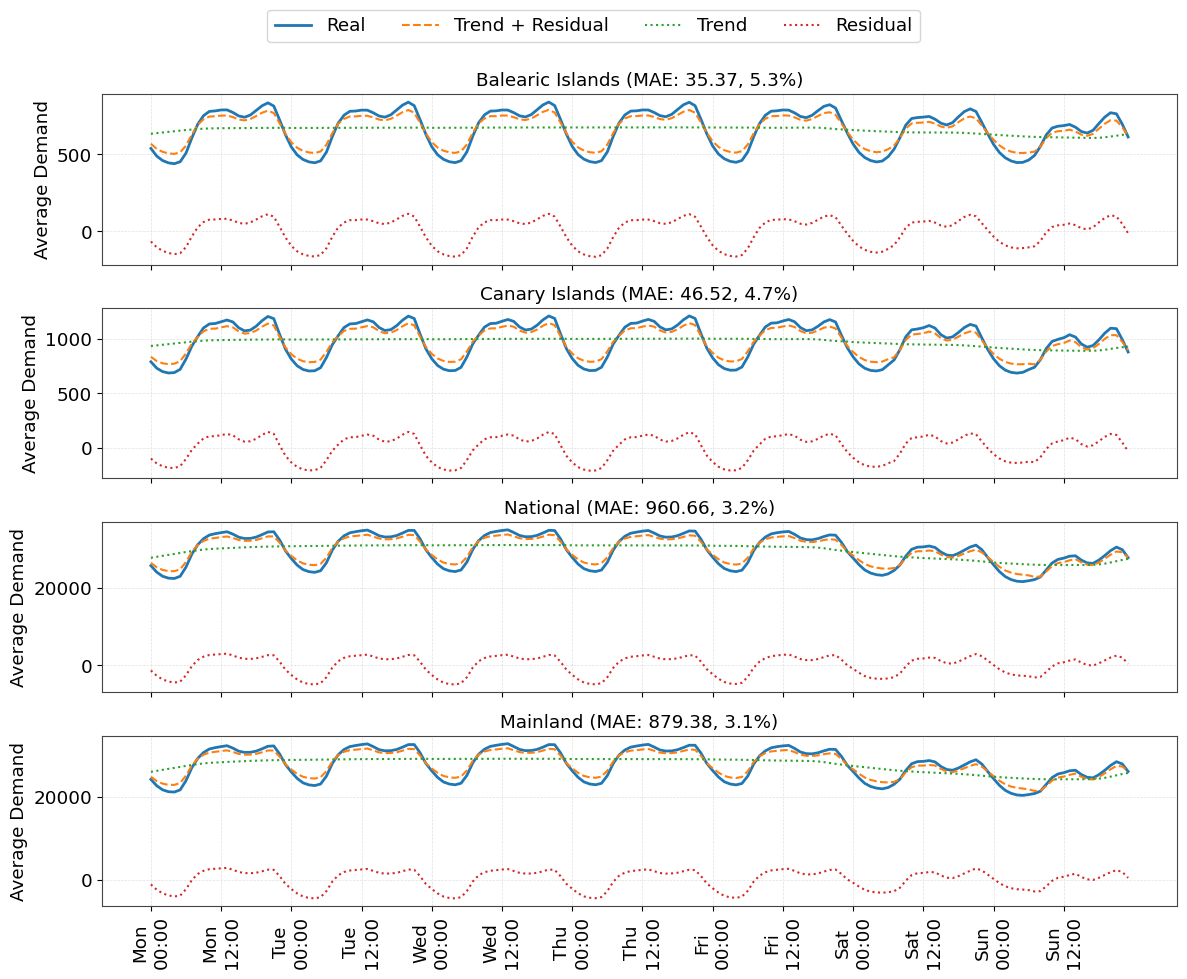

In [21]:
plt.rcParams.update({
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
    'figure.titlesize': 'large'
})

region_map = {
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
}
original_regions = list(region_map.keys())

df = pd.read_csv('data.csv', parse_dates=['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'])
df['region'] = df['region'].map(region_map)
df = df[df['fecha'].dt.year.between(2015, 2023)]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)
axes = axes.flatten()

semana_horas = [(d, h) for d in range(7) for h in range(24)]
x_ticks_labels = [f"{['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][d]}\n{h:02d}:00" for d, h in semana_horas]

for idx, original_region in enumerate(original_regions):
    region_english = region_map[original_region]
    ax = axes[idx]

    values = []

    df_region = df[df['region'] == region_english].copy()

    for _, row in df_region.iterrows():
        fecha = row['fecha']
        weekday = fecha.weekday()
        fecha_trend = fecha + timedelta(days=2)

        trend_row = df_region[df_region['fecha'] == fecha_trend]
        if trend_row.empty:
            continue
        trend_row = trend_row.iloc[0]

        for h in range(24):
            demanda = row.get(f'demanda_{h}', None)
            tendencia = trend_row.get(f'tendencia_demanda_dia_anterior{h}', None)
            residuo = trend_row.get(f'residuo_demanda_dia_anterior{h}', None)
            reconstruido = tendencia + residuo if pd.notna(tendencia) and pd.notna(residuo) else None

            values.append({
                'weekday': weekday,
                'hour': h,
                'demanda': demanda,
                'tendencia': tendencia,
                'residuo': residuo,
                'reconstruido': reconstruido
            })

    df_week = pd.DataFrame(values)
    df_mean = df_week.groupby(['weekday', 'hour']).mean(numeric_only=True).reset_index()
    df_mean['hora_semanal'] = df_mean['weekday'] * 24 + df_mean['hour']

    ax.plot(df_mean['hora_semanal'], df_mean['demanda'], label='Real', linewidth=2)
    ax.plot(df_mean['hora_semanal'], df_mean['reconstruido'], label='Trend + Residual', linestyle='--')
    ax.plot(df_mean['hora_semanal'], df_mean['tendencia'], label='Trend', linestyle=':')
    ax.plot(df_mean['hora_semanal'], df_mean['residuo'], label='Residual', linestyle=':')

    mae = (df_mean['demanda'] - df_mean['reconstruido']).abs().mean()

    media_demanda = df_mean['demanda'].mean()

    mae_pct = (mae / media_demanda) * 100 if media_demanda != 0 else float('nan')

    ax.set_title(f"{region_english} (MAE: {mae:.2f}, {mae_pct:.1f}%)")

    ax.set_ylabel("Average Demand")
    ax.grid(True)
    ax.set_xticks(range(0, 168, 12))  
    ax.set_xticklabels(x_ticks_labels[::12], rotation=90)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.985),
    ncol=4
)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


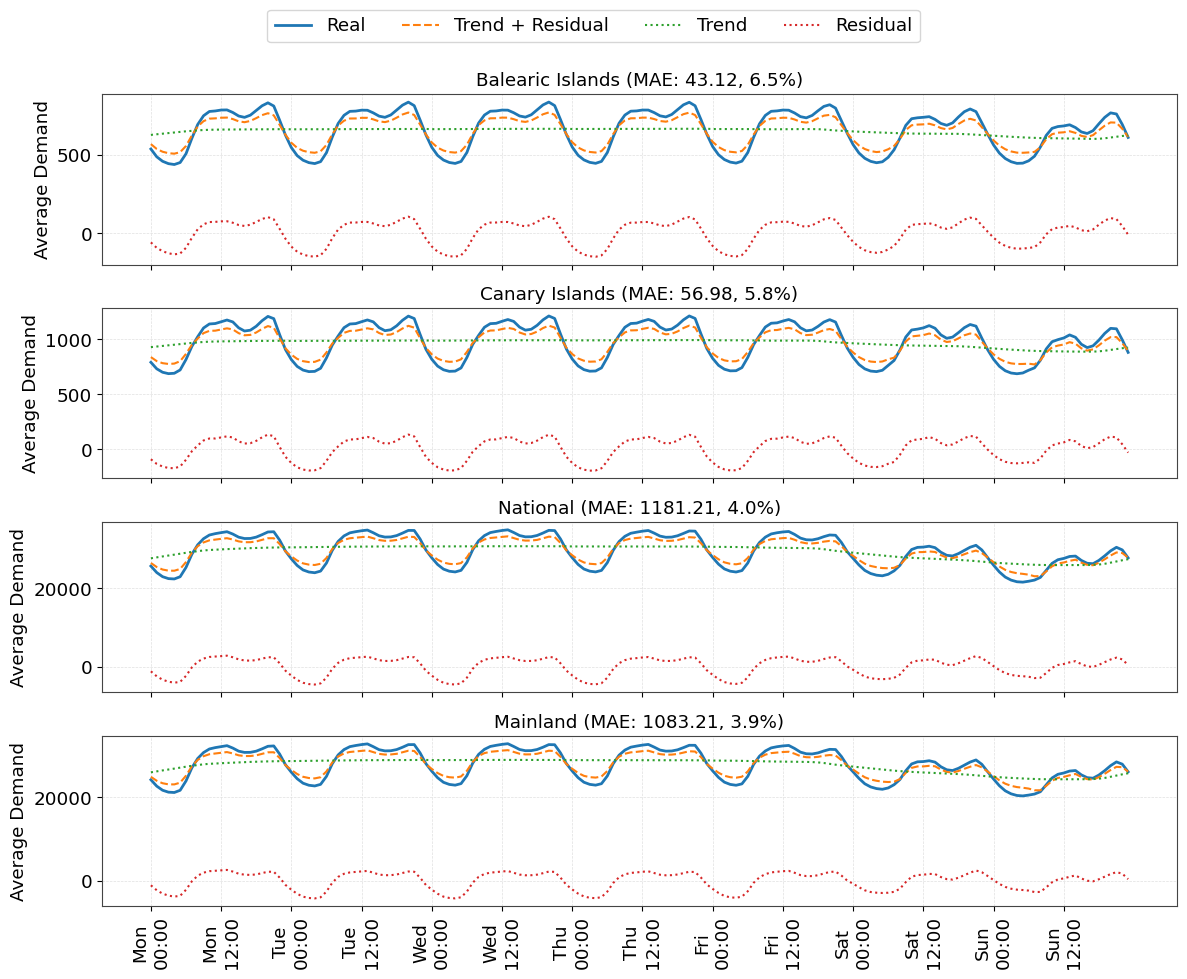

In [22]:
plt.rcParams.update({
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
    'figure.titlesize': 'large'
})

region_map = {
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
}
original_regions = list(region_map.keys())

df = pd.read_csv('data.csv', parse_dates=['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'])
df['region'] = df['region'].map(region_map)
df = df[df['fecha'].dt.year.between(2015, 2023)]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)
axes = axes.flatten()

semana_horas = [(d, h) for d in range(7) for h in range(24)]
x_ticks_labels = [f"{['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][d]}\n{h:02d}:00" for d, h in semana_horas]

for idx, original_region in enumerate(original_regions):
    region_english = region_map[original_region]
    ax = axes[idx]

    values = []

    df_region = df[df['region'] == region_english].copy()

    for _, row in df_region.iterrows():
        fecha = row['fecha']
        weekday = fecha.weekday()
        fecha_trend = fecha + timedelta(days=7)

        trend_row = df_region[df_region['fecha'] == fecha_trend]
        if trend_row.empty:
            continue
        trend_row = trend_row.iloc[0]

        for h in range(24):
            demanda = row.get(f'demanda_{h}', None)
            tendencia = trend_row.get(f'tendencia_demanda_dia_semana_pasada_{h}', None)
            residuo = trend_row.get(f'residuo_demanda_dia_semana_pasada_{h}', None)
            reconstruido = tendencia + residuo if pd.notna(tendencia) and pd.notna(residuo) else None

            values.append({
                'weekday': weekday,
                'hour': h,
                'demanda': demanda,
                'tendencia': tendencia,
                'residuo': residuo,
                'reconstruido': reconstruido
            })

    df_week = pd.DataFrame(values)
    df_mean = df_week.groupby(['weekday', 'hour']).mean(numeric_only=True).reset_index()
    df_mean['hora_semanal'] = df_mean['weekday'] * 24 + df_mean['hour']

    ax.plot(df_mean['hora_semanal'], df_mean['demanda'], label='Real', linewidth=2)
    ax.plot(df_mean['hora_semanal'], df_mean['reconstruido'], label='Trend + Residual', linestyle='--')
    ax.plot(df_mean['hora_semanal'], df_mean['tendencia'], label='Trend', linestyle=':')
    ax.plot(df_mean['hora_semanal'], df_mean['residuo'], label='Residual', linestyle=':')

    mae = (df_mean['demanda'] - df_mean['reconstruido']).abs().mean()

    media_demanda = df_mean['demanda'].mean()

    mae_pct = (mae / media_demanda) * 100 if media_demanda != 0 else float('nan')

    ax.set_ylabel("Average Demand")

    ax.set_title(f"{region_english} (MAE: {mae:.2f}, {mae_pct:.1f}%)")
    ax.grid(True)
    ax.set_xticks(range(0, 168, 12))  
    ax.set_xticklabels(x_ticks_labels[::12], rotation=90)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.985),
    ncol=4
)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


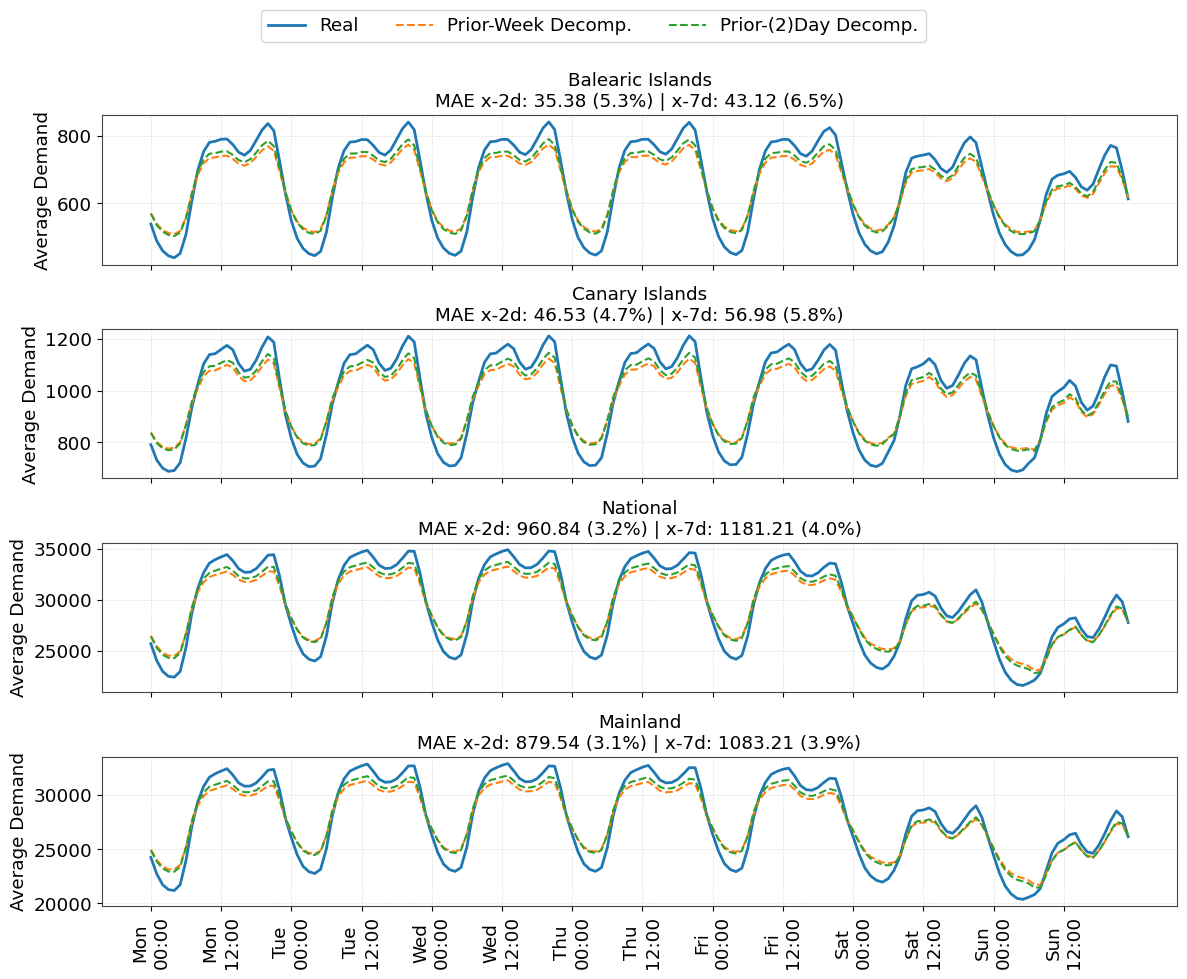

In [23]:
plt.rcParams.update({
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
    'figure.titlesize': 'large'
})

region_map = {
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
}
original_regions = list(region_map.keys())

df = pd.read_csv('data.csv', parse_dates=['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'])
df['region'] = df['region'].map(region_map)
df = df[df['fecha'].dt.year.between(2015, 2023)]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)
axes = axes.flatten()

semana_horas = [(d, h) for d in range(7) for h in range(24)]
x_ticks_labels = [f"{['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][d]}\n{h:02d}:00" for d, h in semana_horas]

for idx, original_region in enumerate(original_regions):
    region_english = region_map[original_region]
    ax = axes[idx]

    values = []

    df_region = df[df['region'] == region_english].copy()

    for _, row in df_region.iterrows():
        fecha = row['fecha']
        weekday = fecha.weekday()
        fecha_trend_s = fecha + timedelta(days=7)
        fecha_trend_d = fecha + timedelta(days=2)

        trend_row_s = df_region[df_region['fecha'] == fecha_trend_s]
        if trend_row_s.empty:
            continue
        trend_row_s = trend_row_s.iloc[0]

        trend_row_d = df_region[df_region['fecha'] == fecha_trend_d]
        if trend_row_d.empty:
            continue
        trend_row_d = trend_row_d.iloc[0]


        for h in range(24):
            demanda = row.get(f'demanda_{h}', None)
            tendencia_s = trend_row_s.get(f'tendencia_demanda_dia_semana_pasada_{h}', None)
            residuo_s = trend_row_s.get(f'residuo_demanda_dia_semana_pasada_{h}', None)
            reconstruido_s = tendencia_s + residuo_s if pd.notna(tendencia_s) and pd.notna(residuo_s) else None

            tendencia_d = trend_row_d.get(f'tendencia_demanda_dia_anterior{h}', None)
            residuo_d = trend_row_d.get(f'residuo_demanda_dia_anterior{h}', None)
            reconstruido_d = tendencia_d + residuo_d if pd.notna(tendencia_d) and pd.notna(residuo_d) else None


            values.append({
                'weekday': weekday,
                'hour': h,
                'demanda': demanda,
                'tendencia_s': tendencia_s,
                'residuo_s': residuo_s,
                'reconstruido_s': reconstruido_s,
                'tendencia_d': tendencia_d,
                'residuo_d': residuo_d,
                'reconstruido_d': reconstruido_d
            })

    df_week = pd.DataFrame(values)
    df_mean = df_week.groupby(['weekday', 'hour']).mean(numeric_only=True).reset_index()
    df_mean['hora_semanal'] = df_mean['weekday'] * 24 + df_mean['hour']

    ax.plot(df_mean['hora_semanal'], df_mean['demanda'], label='Real', linewidth=2)
    ax.plot(df_mean['hora_semanal'], df_mean['reconstruido_s'], label='Prior-Week Decomp.', linestyle='--')
    ax.plot(df_mean['hora_semanal'], df_mean['reconstruido_d'], label='Prior-(2)Day Decomp.', linestyle='--')

    mae_d = (df_mean['demanda'] - df_mean['reconstruido_d']).abs().mean()
    mae_s = (df_mean['demanda'] - df_mean['reconstruido_s']).abs().mean()

    media_demanda = df_mean['demanda'].mean()

    mae_d_pct = (mae_d / media_demanda * 100) if media_demanda != 0 else float('nan')
    mae_s_pct = (mae_s / media_demanda * 100) if media_demanda != 0 else float('nan')

    ax.set_ylabel("Average Demand")

    ax.set_title(f"{region_english}\nMAE x-2d: {mae_d:.2f} ({mae_d_pct:.1f}%) | x-7d: {mae_s:.2f} ({mae_s_pct:.1f}%)")
    ax.set_ylabel("Average Demand")
    ax.grid(True)
    ax.set_xticks(range(0, 168, 12)) 
    ax.set_xticklabels(x_ticks_labels[::12], rotation=90)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.985),
    ncol=4
)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


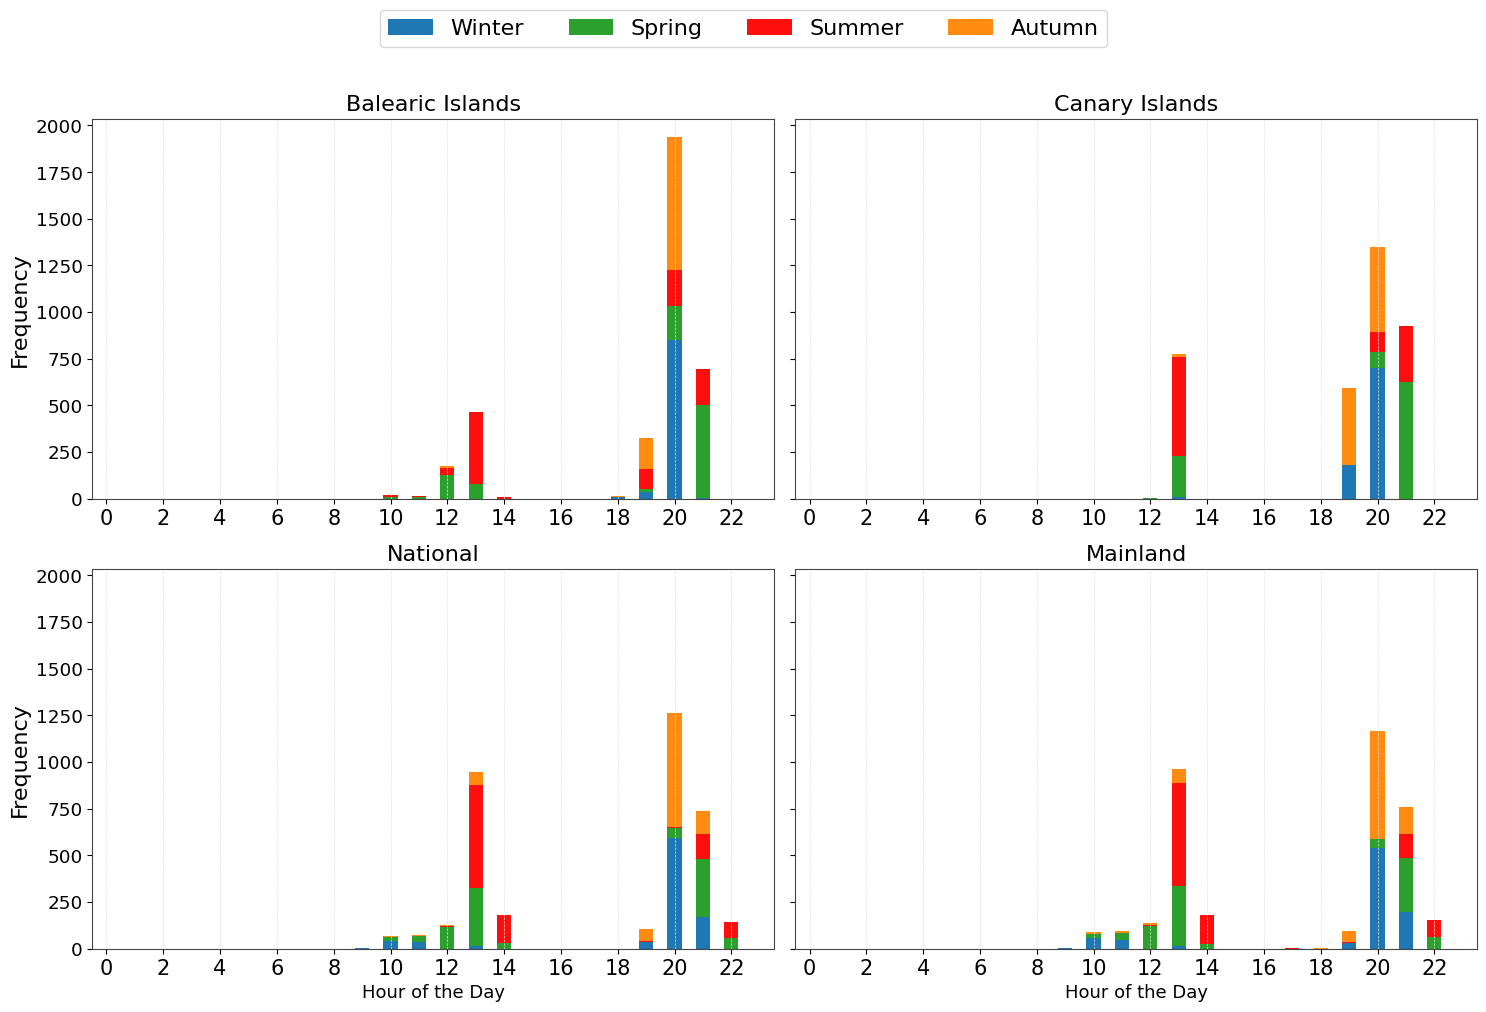

In [27]:
region_map = {
    'Baleares': 'Balearic Islands',
    'Canarias': 'Canary Islands',
    'Nacional': 'National',
    'Peninsular': 'Mainland'
}

df = pd.read_csv('data.csv', parse_dates=['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'])
df['region'] = df['region'].map(region_map)

all_hours = list(range(24))
all_seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

grouped = df.groupby(['region', 'season', 'hora_pico']).size().reset_index(name='count')

pivoted = grouped.pivot_table(
    index=['region', 'hora_pico'],
    columns='season',
    values='count',
    fill_value=0
)

regions = list(region_map.values())
full_index = pd.MultiIndex.from_product([regions, all_hours], names=['region', 'hora_pico'])
pivoted = pivoted.reindex(full_index, fill_value=0).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

season_colors = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': "#ff0e0e",
    'Autumn': "#ff8c10"
}

for idx, region in enumerate(regions):
    ax = axes[idx]
    region_data = pivoted[pivoted['region'] == region].set_index('hora_pico')
    region_data[all_seasons].plot(kind='bar', stacked=True, ax=ax, color=season_colors)

    ax.set_title(region, fontsize=16)
    if idx in [2, 3]:
        ax.set_xlabel('Hour of the Day', fontsize=13)
    else:
        ax.set_xlabel('')
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xticks(range(24))
    xticks = list(range(0, 24, 2)) 
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{h}' for h in xticks], rotation=0, fontsize=15)
    ax.grid(axis='y')
    ax.legend_.remove()


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
